## Introduction
In this notebook, we will explore advanced data cleaning techniques
using the "Titanic: Machine Learning from Disaster" dataset. This dataset includes information about Titanic
passengers, such as age, sex, passenger class, and whether they survived. We will demonstrate how to
handle missing values, detect outliers, and transform categorical variables.


In [1]:
# Libraries we will be using today
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.impute import KNNImputer
from scipy.stats import boxcox
import matplotlib.pyplot as plt


In [2]:
# Loading the Dataset
df = pd.read_csv("Titanic-Dataset.csv")
df.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1. Identifying Outliers


### Identifying Outliers using IQR
Outliers can significantly impact the performance of a model. We will detect and remove outliers in the 'Fare'
column using the Interquartile Range (IQR) method.

### Steps to Identify Outliers using IQR:
1. Calculate the first quartile (Q1) and third quartile (Q3) of the 'Fare' column.
2. Compute the Interquartile Range (IQR) as the difference between Q3 and Q1.
3. Define the lower and upper bounds as Q1 - 1.5 * IQR and Q3 + 1.5 * IQR, respectively.
4. Identify and filter out the data points that lie outside these bounds.

In [4]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Fare'].quantile(0.25)
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identify outliers
outliers = df[(df['Fare'] < lower_bound) | (df['Fare'] > upper_bound)]
# Filter out the outliers
df_filtered = df[(df['Fare'] >= lower_bound) & (df['Fare'] <= upper_bound)]
print("Number of outliers detected:", len(outliers))
print("Data after removing outliers:")
print(df_filtered.shape)


Number of outliers detected: 116
Data after removing outliers:
(775, 12)


# Identifying Outliers using Z-score
The Z-score method is another way to detect outliers by measuring how many standard deviations a data
point is from the mean. Typically, a Z-score threshold of 3 or -3 is used to identify outliers.
### Steps to Identify Outliers using Z-score:
1. Calculate the mean and standard deviation of the 'Fare' column.
2. Compute the Z-score for each data point.
3. Identify and filter out the data points with Z-scores greater than 3 or less than -3.

In [6]:
# Calculate the Z-scores of the 'Fare' column
df['z_score'] = stats.zscore(df['Fare'])
# Identify outliers based on Z-score
z_score_threshold = 3
outliers_z = df[(df['z_score'].abs() > z_score_threshold)]
# Filter out the outliers
df_filtered_z = df[(df['z_score'].abs() <= z_score_threshold)]
print("Number of outliers detected using Z-score:", len(outliers_z))
print("Data after removing outliers using Z-score:")
print(df_filtered_z.shape)


Number of outliers detected using Z-score: 20
Data after removing outliers using Z-score:
(871, 13)


# 2. Imputation
## Simple Imputation
Imputation is the process of replacing missing values in the dataset. Simple imputation involves filling
missing values with a central tendency measure like mean, median, or mode.
### Steps for Simple Imputation:
1. Identify the columns with missing values.
2. Replace missing values with the mean, median, or mode of the column.
We'll demonstrate this by imputing missing values in the 'Age' column with the median age.
#

In [7]:
# Display the number of missing values in each column
print(df.isnull().sum())
# Fill missing values in 'Age' with the median age
df['Age'].fillna(df['Age'].median(), inplace=True)
# Check if the missing values have been filled
print("Number of missing values after imputation:")
print(df.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
z_score          0
dtype: int64
Number of missing values after imputation:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
z_score          0
dtype: int64


## Advanced Imputation using KNN
K-Nearest Neighbors (KNN) imputation is an advanced method that fills missing values by considering the
'k' nearest neighbors' values. It works well when the dataset has patterns that can be leveraged to predict
missing values.
### Steps for KNN Imputation:
1. Select the columns relevant for imputation.
2. Apply KNN imputer to fill the missing values.
We'll use the KNN imputer to handle missing values in the 'Age' column.

In [8]:
# Select relevant columns for imputation
df_impute = df[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']]
# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_impute), columns=df_impute.columns)
# Replace the original 'Age' column with the imputed values
df['Age'] = df_imputed['Age']
# Check if the missing values have been filled
print("Number of missing values after KNN imputation:")
print(df.isnull().sum())


Number of missing values after KNN imputation:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
z_score          0
dtype: int64


# 3. Transformation
## Log Transformation
Log transformation is used to stabilize the variance of data and make it more normally distributed. It's
particularly useful for right-skewed data.
### Steps for Log Transformation:
1. Identify the skewed column in the dataset.
2. Apply the log transformation to the column.
We'll apply the log transformation to the 'Fare' column to reduce its skewness

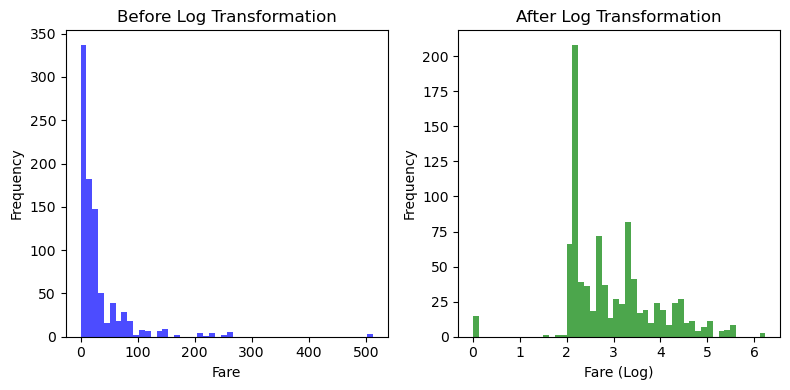

In [9]:
# Display the distribution of the 'Fare' column before transformation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(df['Fare'], bins=50, color='blue', alpha=0.7)
plt.title('Before Log Transformation')
plt.xlabel('Fare')
plt.ylabel('Frequency')
# Apply log transformation (adding 1 to avoid log(0))
df['Fare_log'] = np.log(df['Fare'] + 1)
# Display the distribution of the 'Fare' column after transformation
plt.subplot(1, 2, 2)
plt.hist(df['Fare_log'], bins=50, color='green', alpha=0.7)
plt.title('After Log Transformation')
plt.xlabel('Fare (Log)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Box-Cox Transformation
The Box-Cox transformation is a more generalized transformation technique that can stabilize variance and
make the data more normally distributed. It can be applied to positive data only.
### Steps for Box-Cox Transformation:
1. Identify the skewed column in the dataset.
2. Apply the Box-Cox transformation to the column.
We'll apply the Box-Cox transformation to the 'Fare' column

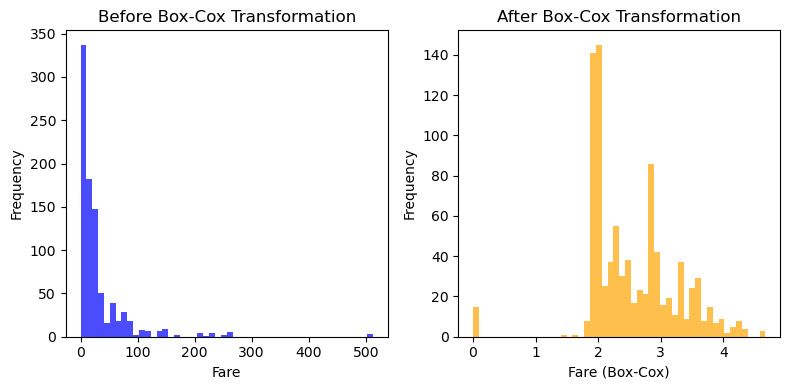

In [10]:
# Apply Box-Cox transformation (Box-Cox requires strictly positive values)
df['Fare_boxcox'], fitted_lambda = boxcox(df['Fare'] + 1) # Adding 1 to avoid zero values
# Display the distribution of the 'Fare' column after Box-Cox transformation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(df['Fare'], bins=50, color='blue', alpha=0.7)
plt.title('Before Box-Cox Transformation')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(df['Fare_boxcox'], bins=50, color='orange', alpha=0.7)
plt.title('After Box-Cox Transformation')
plt.xlabel('Fare (Box-Cox)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()